In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV, KFold
from surprise import SVD, NMF, SVDpp, accuracy, Dataset, Reader
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate

## Data manipulation

### Data loading

Each data file (there are 4 of them) contains below columns:

* Movie ID (as first line of each new movie record / file)
* Customer ID
* Rating (1 to 5)
* Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

In [2]:
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print(f'Dataset 1 shape: {df1.shape}')
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [3]:
#df2 = pd.read_csv('../input/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('../input/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('../input/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

In [4]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print(f'Full dataset shape: {df.shape}')
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


### DATA VIEWING

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum().iloc[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

print(f'Total Movies: {movie_count}')
print(f'Total Customers: {cust_count}')
print(f'Total Ratings Given: {rating_count}')

Total Movies: 4499
Total Customers: 470758
Total Ratings Given: 24053764


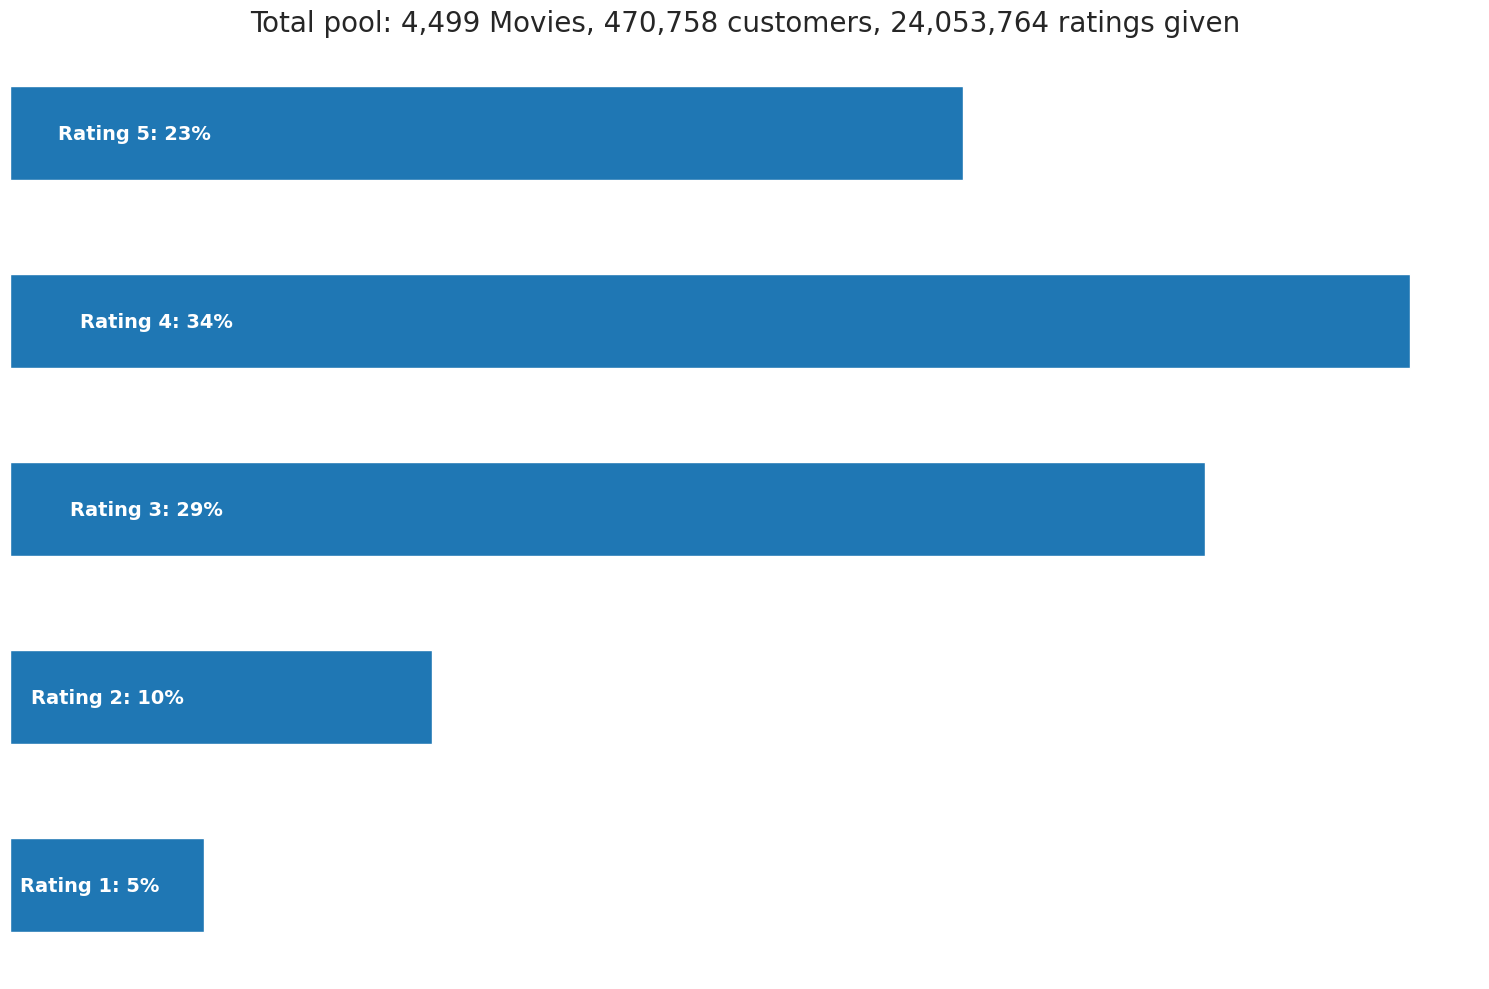

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("white")

# Create the bar plot with a specific color palette
ax = p.plot(kind='barh', legend=False, figsize=(15, 10))

# Set the title with an increased font size
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)

# Remove the axes
plt.axis('off')

# Customize the text color, size, and add the percentages with an increased font size
for i in range(1, 6):
    value = p.iloc[i-1][0]
    pct = value * 100 / p.sum()[0]
    ax.text(value * 0.05, i-1, 'Rating {}: {:.0f}%'.format(i, pct), color='white', weight='bold', va='center', fontsize=14)

# Tight layout often produces a nice, compact plot
plt.tight_layout()

# Show the plot
plt.show()


We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

In [7]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [8]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

In [9]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [10]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::500000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
697594     284111     2.0       187
1374441   1300759     4.0       295
2050979   2180274     4.0       371
2766827   1746056     4.0       494
3454674   2617121     4.0       658
4110584   1662445     4.0       788
4792130    772327     4.0       962
5473490    953111     3.0      1110
6201216    140162     3.0      1216
6932490   1299309     5.0      1384
7644969   1577606     5.0      1542
8297227   1488466     4.0      1650
8957043   2425325     3.0      1795
9636748   2467323     4.0      1890
10365846   761585     3.0      2009
11061852  2040374     3.0      2152
11780090  1349907     5.0      2252
12491164  2235049     3.0      2391
13157072  2162641     1.0      2482
13860273   400155     3.0      2660
14541902  1691537     4.0      2800
15249127  2432905     3.0      2922
15920960  1814344     5.0      3106
16618125  1979820     

## Data mapping
Now we load the movie mapping file:

In [12]:
df_title = pd.read_csv('movie_titles.csv', index_col = None, encoding = "ISO-8859-1", header = None, names = ['Movie_Id','Year', 'Name'])
df_title['Name'] = df_title['Year'].copy()
df_title['Year'] = df_title['Movie_Id'].copy()
df_title = df_title.drop('Movie_Id', axis = 1).copy()
df_title = df_title.rename_axis('Movie_Id')
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [13]:
# Create a Reader object
reader = Reader()

#Load Data
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)

# Split data into trainset and testset
trainset = data.build_full_trainset()

In [14]:
# Recommendations using SVD
svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8484  0.8483  0.8488  0.8474  0.8476  0.8481  0.0005  
MAE (testset)     0.6586  0.6588  0.6592  0.6581  0.6582  0.6586  0.0004  
Fit time          144.72  149.38  150.49  149.58  149.05  148.64  2.02    
Test time         50.03   36.44   50.31   40.03   40.20   43.41   5.69    


{'test_rmse': array([0.84835238, 0.84830944, 0.84879413, 0.84743622, 0.84755809]),
 'test_mae': array([0.65864445, 0.65884288, 0.65915438, 0.65811109, 0.65823783]),
 'fit_time': (144.72411227226257,
  149.37584233283997,
  150.48545813560486,
  149.57753801345825,
  149.05085229873657),
 'test_time': (50.02881646156311,
  36.44375705718994,
  50.31419777870178,
  40.03388833999634,
  40.204763650894165)}

In [15]:
# Fit to the svd object
svd.fit(trainset)

In [ ]:
####### TRAINING SVD++ REQUIRED RESOURCES OUT OF OUR HARDWARE CAPABILITIES #######
# Recommendations using SVD++
#svdpp = SVDpp()

# Evaluate Performance
#cross_validate(svdpp, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [17]:
# Fit to the svd++ object
#svdpp.fit(trainset)

In [18]:
# Recommendations using NMF
nmf = NMF()

# Evaluate Performance
cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9086  0.9086  0.9101  0.9066  0.9070  0.9082  0.0013  
MAE (testset)     0.7123  0.7131  0.7136  0.7105  0.7110  0.7121  0.0012  
Fit time          272.35  265.05  266.42  265.61  265.16  266.92  2.76    
Test time         36.65   34.15   40.43   43.02   43.20   39.49   3.57    


{'test_rmse': array([0.90858294, 0.90857626, 0.91013155, 0.90659905, 0.90700171]),
 'test_mae': array([0.71233385, 0.71308006, 0.71364586, 0.71054737, 0.71097321]),
 'fit_time': (272.34994077682495,
  265.05138659477234,
  266.42023754119873,
  265.6104242801666,
  265.1611201763153),
 'test_time': (36.647165060043335,
  34.15047574043274,
  40.42746424674988,
  43.017218351364136,
  43.19506335258484)}

In [19]:
# Fit to the nmf object
nmf.fit(trainset)

### Making Predictions

Below is what user 83510 liked in the past:

In [20]:
df_83510 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_83510 = df_83510.set_index('Movie_Id')
df_83510 = df_83510.join(df_title)['Name']
print(df_83510)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

Let's predict which movies user 85310 would love to watch:

In [21]:
def recommend(user_id, algo):
    user_df = df_title.copy()
    user_df = user_df.reset_index()
    user_df = user_df[~user_df['Movie_Id'].isin(drop_movie_list)]

    user_df['Estimate_Score'] = user_df['Movie_Id'].apply(lambda x: algo.predict(user_id, x).est)

    user_df = user_df.drop('Movie_Id', axis = 1)

    user_df = user_df.sort_values('Estimate_Score', ascending=False)
    
    return user_df.head(10)

In [22]:
# Recommend top 10 movies for user id 85310 using SVD
recommendations = recommend(85310, svd)
print("Recommendations using SVD: ")
print(recommendations)

Recommendations using SVD: 
        Year                                           Name  Estimate_Score
3455  2004.0                                 Lost: Season 1        4.603793
4426  2001.0                        The West Wing: Season 3        4.528753
2113  2002.0                                        Firefly        4.442260
2101  1994.0                         The Simpsons: Season 6        4.403463
3443  2004.0          Family Guy: Freakin' Sweet Collection        4.373661
1475  2004.0                       Six Feet Under: Season 4        4.355163
3961  2003.0                      Finding Nemo (Widescreen)        4.315843
2451  2001.0  Lord of the Rings: The Fellowship of the Ring        4.288986
4237  2000.0                                      Inu-Yasha        4.283416
2056  2001.0             Buffy the Vampire Slayer: Season 6        4.279604


In [24]:
# Recommend top 10 movies for user id 85310 using NMF
recommendations = recommend(85310, nmf)
print("Recommendations using NMF: ")
print(recommendations)

Recommendations using NMF: 
         Year                                               Name  \
17769  2003.0                                       Alien Hunter   
2      1997.0                                          Character   
7      2004.0                         What the #$*! Do We Know!?   
15     1996.0                                          Screamers   
16     2005.0                                          7 Seconds   
17     1994.0                                   Immortal Beloved   
25     2004.0                                    Never Die Alone   
27     2002.0                                    Lilo and Stitch   
29     2003.0                             Something's Gotta Give   
31     2004.0  ABC Primetime: Mel Gibson's The Passion of the...   

       Estimate_Score  
17769         3.59057  
2             3.59057  
7             3.59057  
15            3.59057  
16            3.59057  
17            3.59057  
25            3.59057  
27            3.59057  
29     